In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Phoneme Dataset
Load the phoneme dataset using Pandas


In [3]:
df = pd.read_csv('data/phoneme.csv')
# print(data)

# For the speaker variable, as well as the phoneme variable `g`, we can make use of the pandas `category` data type
df = df.astype({'g':'category','speaker':'category'})

X = np.array(df.drop(['row.names', 'g', 'speaker'], axis=1))

speaker = df.speaker

# Split the dataset into a train and test dataset according to column "speaker".
# Be sure to exclude row number, "speaker" and response columns from your features.

cat_names = df.g.cat.categories
y = df.g.cat.codes

y = np.array(y)
X = np.array(X)
print(X.shape)

(4509, 256)


In [4]:
def split_by(X,y,tst_by):
    from types import SimpleNamespace
    return SimpleNamespace(x_tst=X[tst_by],y_tst=y[tst_by],
                           x_trn=X[~tst_by],y_trn=y[~tst_by])

data = split_by(X,y,tst_by=df.speaker.str.startswith('test'))

### 2. LDA modelling
Fit an LDA model. Compute and report the train and test error.

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def fit_discriminant_analysis(data, cls=LinearDiscriminantAnalysis,quiet=False):
    from types import SimpleNamespace
    clf = cls()
    clf.fit(data.x_trn, data.y_trn)
    def get_model_acc(X, y):
        pred = clf.predict(X)
        return np.mean(pred == y)
    acc_trn = get_model_acc(data.x_trn,data.y_trn)
    acc_tst = get_model_acc(data.x_tst,data.y_tst)
    if not quiet:
        print(f'The accuracy of the model is:\nTrain:\t{acc_trn*100:.4f}%\nTest:\t{acc_tst*100:.4f}%')
    return clf,SimpleNamespace(trn=acc_trn, tst=acc_tst)
clf_lda6,acc_lda6 = fit_discriminant_analysis(data)


The accuracy of the model is:
Train:	94.4012%
Test:	91.9589%


### 3. LDA on different phonemes
For every pair of phenomes select the corresponding data points. Fit an LDA model on all data sets and repeat the steps done in (2). Explain your findings.

In [30]:
import itertools
def filter_y(data, keep_only):
    from types import SimpleNamespace
    idx_tst = np.isin(data.y_tst,keep_only)
    idx_trn = np.isin(data.y_trn,keep_only)
    return SimpleNamespace(x_tst=data.x_tst[idx_tst,:],y_tst=data.y_tst[idx_tst],
                           x_trn=data.x_trn[idx_trn,:],y_trn=data.y_trn[idx_trn])
    


for vo1,vo2 in itertools.combinations(['sh', 'iy', 'dcl', 'aa', 'ao'],2):
    print("LDA for", vo1,vo2)
    idl_kept = np.where(cat_names.isin([vo1,vo2]))[0]
    cat_names2 = cat_names[idl_kept]
    data2 = filter_y(data, idl_kept)
    clf_lda2,acc_lda2 = fit_discriminant_analysis(data2)

LDA for sh iy
The accuracy of the model is:
Train:	100.0000%
Test:	100.0000%
LDA for sh dcl
The accuracy of the model is:
Train:	99.9174%
Test:	100.0000%
LDA for sh aa
The accuracy of the model is:
Train:	100.0000%
Test:	100.0000%
LDA for sh ao
The accuracy of the model is:
Train:	100.0000%
Test:	100.0000%
LDA for iy dcl
The accuracy of the model is:
Train:	100.0000%
Test:	98.6166%
LDA for iy aa
The accuracy of the model is:
Train:	100.0000%
Test:	100.0000%
LDA for iy ao
The accuracy of the model is:
Train:	100.0000%
Test:	99.8258%
LDA for dcl aa
The accuracy of the model is:
Train:	99.9075%
Test:	100.0000%
LDA for dcl ao
The accuracy of the model is:
Train:	100.0000%
Test:	100.0000%
LDA for aa ao
The accuracy of the model is:
Train:	89.3584%
Test:	78.5877%


The vocalization of "aa" and "ao" is similar, in contrast to the other pairs. -> Harder to distinguish,
which may explain difference in performance.

### 4. QDA
Repeat steps (b) and (d) using QDA and report your findings. Would you prefer LDA or QDA in this example? Why?

In [29]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
for vo1,vo2 in itertools.combinations(['sh', 'iy', 'dcl', 'aa', 'ao'],2):
    print("QDA for", vo1,vo2)
    idl_kept = np.where(cat_names.isin([vo1,vo2]))[0]
    cat_names2 = cat_names[idl_kept]
    data2 = filter_y(data, idl_kept)
    clf_lda2,acc_lda2 = fit_discriminant_analysis(data2,cls=QuadraticDiscriminantAnalysis)


QDA for sh iy
The accuracy of the model is:
Train:	100.0000%
Test:	99.8131%
QDA for sh dcl
The accuracy of the model is:
Train:	100.0000%
Test:	99.2840%
QDA for sh aa
The accuracy of the model is:
Train:	100.0000%
Test:	98.0000%
QDA for sh ao
The accuracy of the model is:
Train:	100.0000%
Test:	99.7947%
QDA for iy dcl
The accuracy of the model is:
Train:	100.0000%
Test:	94.0711%
QDA for iy aa
The accuracy of the model is:
Train:	100.0000%
Test:	98.1520%
QDA for iy ao
The accuracy of the model is:
Train:	100.0000%
Test:	99.8258%
QDA for dcl aa
The accuracy of the model is:
Train:	100.0000%
Test:	97.8437%
QDA for dcl ao
The accuracy of the model is:
Train:	100.0000%
Test:	100.0000%
QDA for aa ao
The accuracy of the model is:
Train:	100.0000%
Test:	66.0592%


LDA is preferable, since QDA overfits. Train Accuracy >> Test accuracy.

### 5. Confusion Matrices
Generate confusion matrices for the LDA and QDA model for the combination of phenomes, which proved to be the hardest to classify. 

In [31]:
def show_cm(X,y,clf, nrm=False):
    cm = confusion_matrix(y, clf.predict(X))
    if nrm:
        cm = cm/cm.sum()*100
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=plt.gca())
    plt.xticks([0,1],cat_names2)
    plt.yticks([0,1],cat_names2)

def show_data_cm(data, clf, nrm=False):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.title('Train')
    show_cm(data.x_trn,data.y_trn,clf,nrm=nrm)
    plt.subplot(1,2,2)
    plt.title('Test')
    show_cm(data.x_tst,data.y_tst,clf,nrm=nrm)

idl_kept = np.where(cat_names.isin([vo1,vo2]))[0]
cat_names2 = cat_names[idl_kept]
data2 = filter_y(data, idl_kept)

For LDA we compute the confusion matrices

The accuracy of the model is:
Train:	89.3584%
Test:	78.5877%


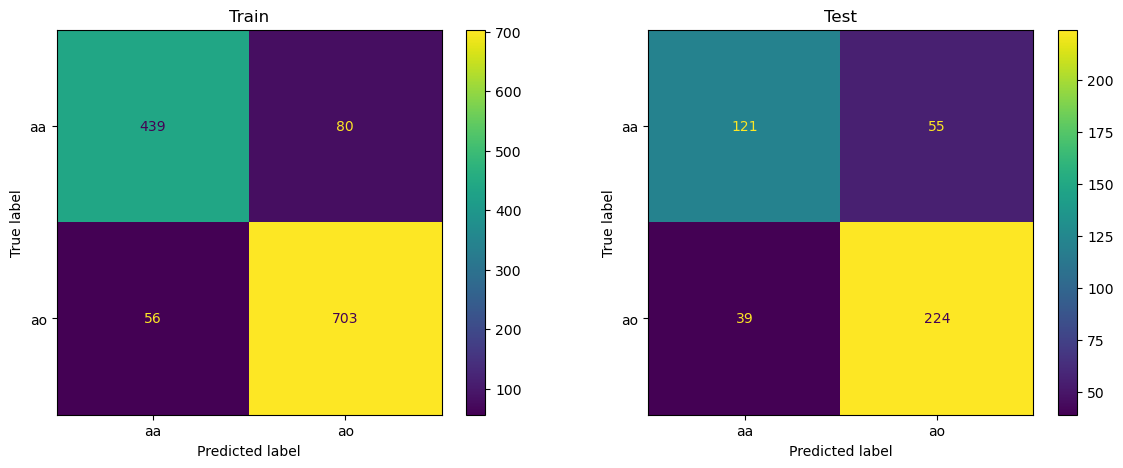

In [33]:
clf_lda,_ = fit_discriminant_analysis(data2,cls=LinearDiscriminantAnalysis)
show_data_cm(data2, clf_lda)

For QDA they become

The accuracy of the model is:
Train:	100.0000%
Test:	66.0592%


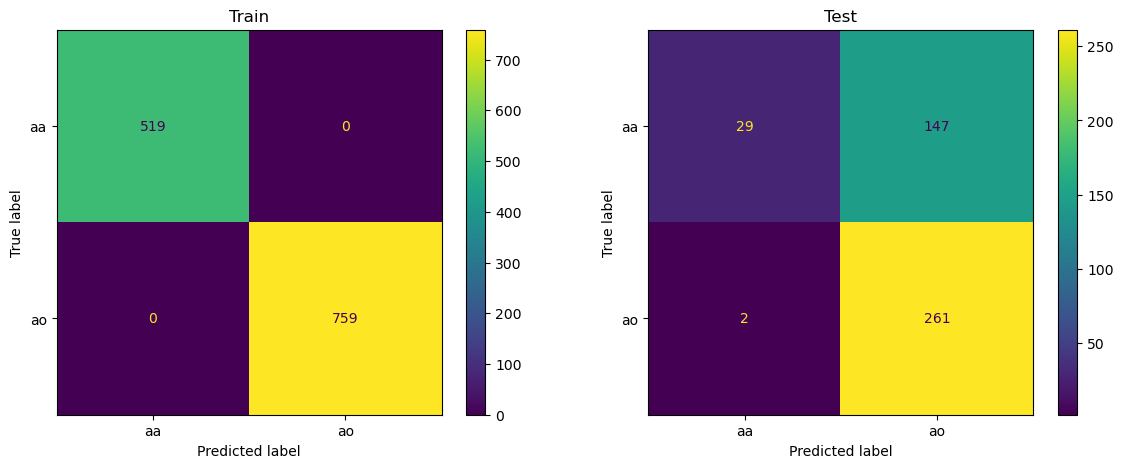

In [35]:
clf_qda,_ = fit_discriminant_analysis(data2,cls=QuadraticDiscriminantAnalysis)
show_data_cm(data2, clf_qda)

In this example we can see that QDA is clearly overfitting the two phonemes, since its training accuracy is 100%, but the testing accuracy is very low.

In addition, the predictor opts much more in favour of the most likely class, which is class 1, and the errors are not balanced between the two classes.

Therefore, the simpler model of LDA is preferred.